# Desiderata

In [15]:
library(here)
source(here("code/setup.R"))


Warning message:
“Removed 2148 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 2148 rows containing missing values or values outside the scale range
(`geom_line()`).”


pdf 
  2

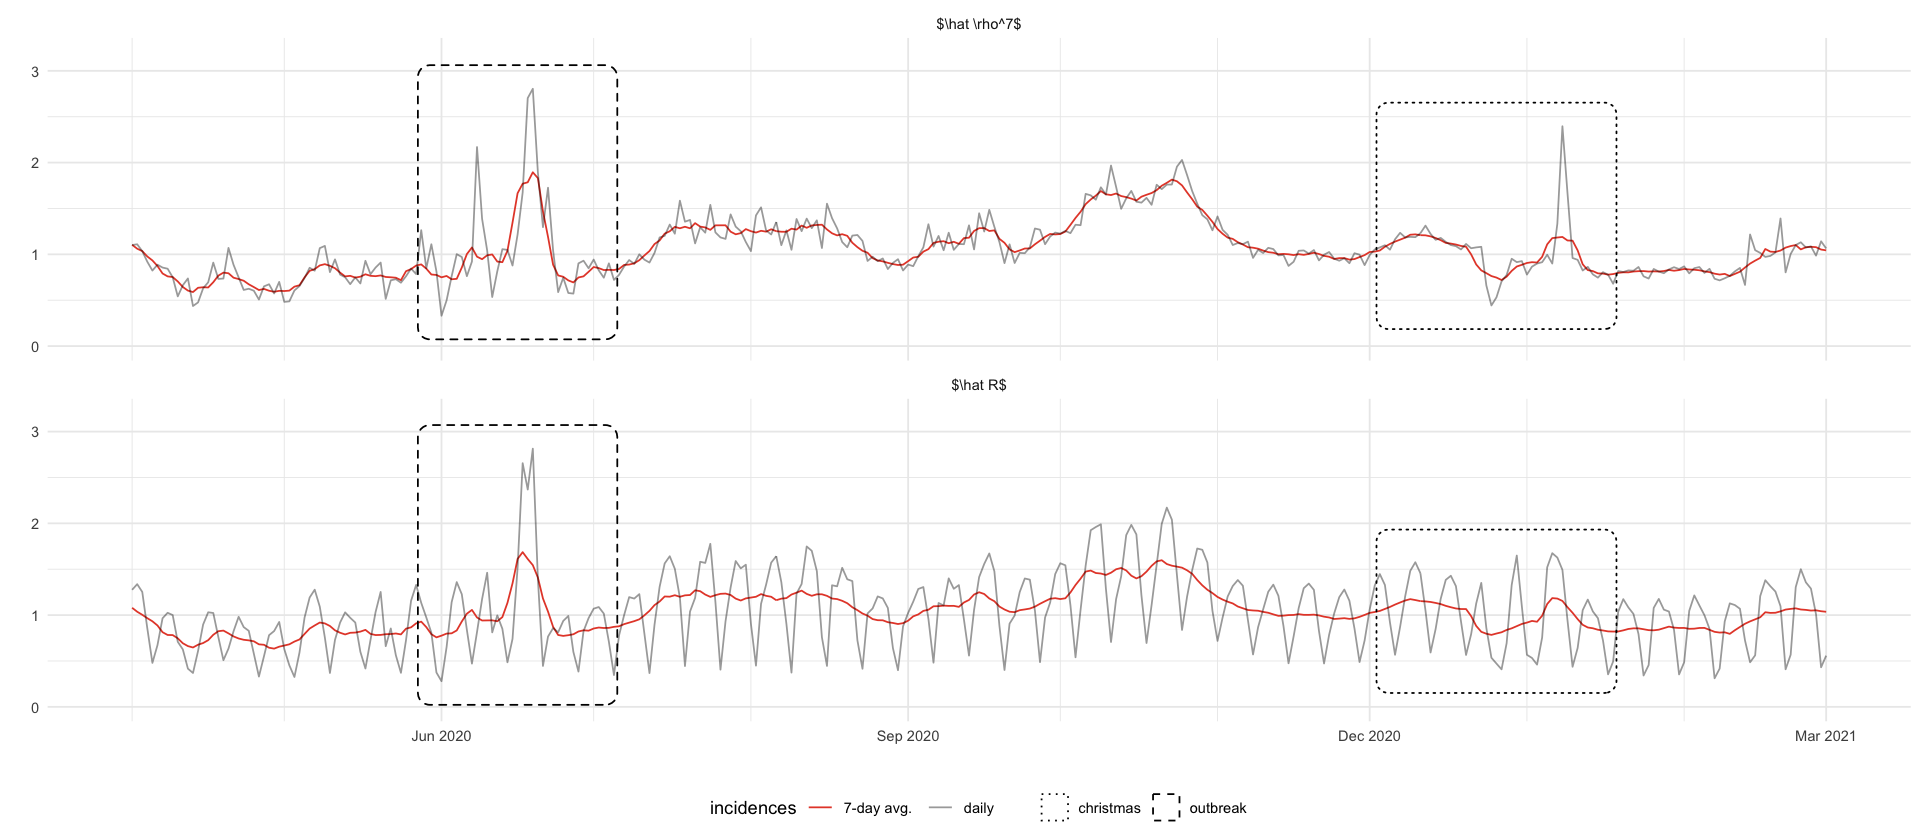

In [39]:
w_df <- read_csv(here("data/processed/generation_time.csv"))
w <- w_df$w

estimate_R <- function(I, w) {
    I_ext <- c(rep(0, length(w) - 1), I)
    I / stats::filter(I_ext, c(0, w), sides = 1, method = "convolution")[-(1:(length(w) - 1))]
}

estimate_rho <- function(I) {
    I / lag(I, 7)
}



stopifnot(length(estimate_R(rpois(100, 10), w)) == 100)

rki <- read_csv(here("data/processed/rki_county.csv"))


rki %>%
    group_by(date) %>%
    summarize(cases = sum(cases)) %>%
    mutate(cases_7 = rollmean(cases, k = 7, fill = NA)) %>%
    mutate(R = estimate_R(cases, w)) %>%
    mutate(R_7 = estimate_R(cases_7, w)) %>%
    mutate(rho = estimate_rho(cases)) %>%
    mutate(rho_7 = estimate_rho(cases_7)) %>%
    filter(date >= "2020-04-01") %>%
    select(date, R:rho_7) %>%
    pivot_longer(-date) %>%
    mutate(type = ifelse(str_starts(name, "R"), "$\\hat R$", "$\\hat \\rho^7$")) %>%
    mutate(timescale = ifelse(str_ends(name, "_7"), "7-day avg.", "daily")) %>%
    ggplot(aes(date, value, color = timescale, alpha = timescale, group = timescale)) +
    geom_line() +
    facet_wrap(~type, scales = "free_y", nrow = 2) +
    scale_color_manual(values = c("daily" = "black", "7-day avg." = pal_npg()(1))) +
    scale_alpha_manual(values = c("daily" = .4, "7-day avg." = 1)) +
    coord_cartesian(ylim = c(0, 3.2)) +
    scale_x_date(date_minor_breaks = "1 month", limits = c(ymd("2020-04-01"), ymd("2021-03-01")), date_breaks = "3 months", date_labels = "%b %Y") +
    theme(legend.position = "bottom") +
    geom_mark_rect(
        aes(
            x = date, y = value,
            filter = (date <= ymd("2020-07-01") & date >= ymd("2020-06-01")), group = type, linetype = "outbreak"
        ),
        inherit.aes = FALSE
    ) +
    geom_mark_rect(
        aes(
            x = date, y = value,
            filter = (date >= ymd("2020-12-07") & date <= ymd("2021-01-14")),
            group = type, linetype = "christmas"
        ),
        inherit.aes = FALSE
    ) +
    scale_linetype_manual(values = c("outbreak" = "dashed", "christmas" = "dotted")) +
    labs(x = "", y = "", color = "incidences", alpha = "incidences", linetype = "")
# geom_magnify( # Toennies
#    from = list(ymd("2020-06-01"), ymd("2020-07-01"), .6, 2.2),
#    to = list(ymd("2020-08-01"), ymd("2020-10-14"), 2.1, 3),
#    axes = "x"
# )
# geom_magnify( # christmas
#    from = list(ymd("2020-12-07"), ymd("2021-01-14"), .5, 1.5),
#    to = list(ymd("2021-03-01"), ymd("2021-07-01"), 2.2, 3.9),
#    axes = "x"
# )

ggsave_tikz(here("tikz/rho_and_R_naive.tex"))
